# Short Term Load Forecasting using XGBoost

This notebook demonstrates the use of XGBoost for short term load forecasting. It follows the steps in ["Short Term Load Forecasting Using XGBoost"](https://doi.org/10.1007/978-3-030-15035-8_108).

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tqdm import tqdm

import time
import pickle
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12.8, 7.2)


In [2]:
df = pd.read_csv('../data/BANES_v2.csv', parse_dates=['time'])
# df = df.groupby(['time', 'location']).mean().reset_index()
df.head()

KeyboardInterrupt: 

In [ ]:
df = df.sort_values(by=['location', 'time'])

Joining the last week of data will expand the usage up to almost 20 GiB of data. That's too large for the RAM and unnecessary for this.
We will use only around 3 years of data to reduce the RAM usage.

In [ ]:
df = df[df['time'] >= '2017-01-01']

In [5]:
# join the last 7 days of data
for i in tqdm(range(1, 48 * 7 + 1)):
    df.loc[df['time'].shift(i) == df['time'] - pd.Timedelta(i * 30, 'm'), f"energy_lag_{i}"] = df['energy'].shift(i)

100%|██████████| 336/336 [01:51<00:00,  3.02it/s]


In [6]:
df.dropna(inplace=True)
df.head()

,location,time,energy,AirTemp,RelativeHumidity,Dni,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,...,energy_lag_327,energy_lag_328,energy_lag_329,energy_lag_330,energy_lag_331,energy_lag_332,energy_lag_333,energy_lag_334,energy_lag_335,energy_lag_336
188447,##Bishop Sutton Primary School Electricity,2017-01-08 00:00:00+00:00,0.000,8.4,0.987,0.0,0.000,0.0,0.0,0.0,...,0.005,0.005,0.005,0.005,0.006,0.005,0.005,0.000,0.000,0.000
188448,##Bishop Sutton Primary School Electricity,2017-01-08 00:30:00+00:00,0.000,8.3,0.987,0.0,0.000,0.0,0.0,0.0,...,0.006,0.005,0.005,0.005,0.005,0.006,0.005,0.005,0.000,0.000
188449,##Bishop Sutton Primary School Electricity,2017-01-08 01:00:00+00:00,0.000,8.2,0.987,0.0,0.000,0.0,0.0,0.0,...,0.005,0.006,0.005,0.005,0.005,0.005,0.006,0.005,0.005,0.000
188450,##Bishop Sutton Primary School Electricity,2017-01-08 01:30:00+00:00,0.006,8.1,0.987,0.0,0.000,0.0,0.0,0.0,...,0.005,0.005,0.006,0.005,0.005,0.005,0.005,0.006,0.005,0.005
188451,##Bishop Sutton Primary School Electricity,2017-01-08 02:00:00+00:00,0.005,8.0,0.988,0.0,0.006,0.0,0.0,0.0,...,0.005,0.005,0.005,0.006,0.005,0.005,0.005,0.005,0.006,0.005


In [7]:
# df.to_csv('../data/BANES_v3_oneweek.csv', index=False)

## Feature Selection

In [3]:
df = pd.read_csv('../data/BANES_v3_oneweek.csv', parse_dates=['time'])
df.head()

,location,time,energy,AirTemp,RelativeHumidity,Dni,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,...,energy_lag_327,energy_lag_328,energy_lag_329,energy_lag_330,energy_lag_331,energy_lag_332,energy_lag_333,energy_lag_334,energy_lag_335,energy_lag_336
0,##Bishop Sutton Primary School Electricity,2017-01-08 00:00:00+00:00,0.000,8.4,0.987,0.0,0.000,0.0,0.0,0.0,...,0.005,0.005,0.005,0.005,0.006,0.005,0.005,0.000,0.000,0.000
1,##Bishop Sutton Primary School Electricity,2017-01-08 00:30:00+00:00,0.000,8.3,0.987,0.0,0.000,0.0,0.0,0.0,...,0.006,0.005,0.005,0.005,0.005,0.006,0.005,0.005,0.000,0.000
2,##Bishop Sutton Primary School Electricity,2017-01-08 01:00:00+00:00,0.000,8.2,0.987,0.0,0.000,0.0,0.0,0.0,...,0.005,0.006,0.005,0.005,0.005,0.005,0.006,0.005,0.005,0.000
3,##Bishop Sutton Primary School Electricity,2017-01-08 01:30:00+00:00,0.006,8.1,0.987,0.0,0.000,0.0,0.0,0.0,...,0.005,0.005,0.006,0.005,0.005,0.005,0.005,0.006,0.005,0.005
4,##Bishop Sutton Primary School Electricity,2017-01-08 02:00:00+00:00,0.005,8.0,0.988,0.0,0.006,0.0,0.0,0.0,...,0.005,0.005,0.005,0.006,0.005,0.005,0.005,0.005,0.006,0.005


In [4]:
df.shape

(2466431, 342)

In [5]:
df.shape[0] * df.shape[1]

843519402

3 years of data is still too large. We'll only use around one year and half.

In [6]:
df = df[(df['time'] >= '2019-01-01') & (df['time'] < '2020-01-01')]

X_vals = df.drop(['energy', 'location', 'time'], axis=1).values
y_vals = df['energy'].values

X_vals[:5], y_vals[:5]

(array([[13.9  ,  0.937,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [13.9  ,  0.942,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [14.   ,  0.948,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [14.1  ,  0.951,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [14.1  ,  0.952,  0.   , ...,  0.   ,  0.   ,  0.   ]]),
 array([1.347, 1.384, 1.344, 1.394, 1.34 ]))

In [7]:
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5, tree_method='gpu_hist', verbosity=2)

In [8]:
init = time.time()
model.fit(X_vals, y_vals)
end = time.time()

print('Training time: {:.4f} s'.format(end - init))

Training time: 259.9533 s


In [9]:

# pickle.dump(model, open('../models/model_featureimportance.pkl', 'wb'))

In [10]:
columns = df.drop(['energy', 'location', 'time'], axis=1).columns

In [11]:
feature_importance = pd.Series(model.feature_importances_, index=columns)

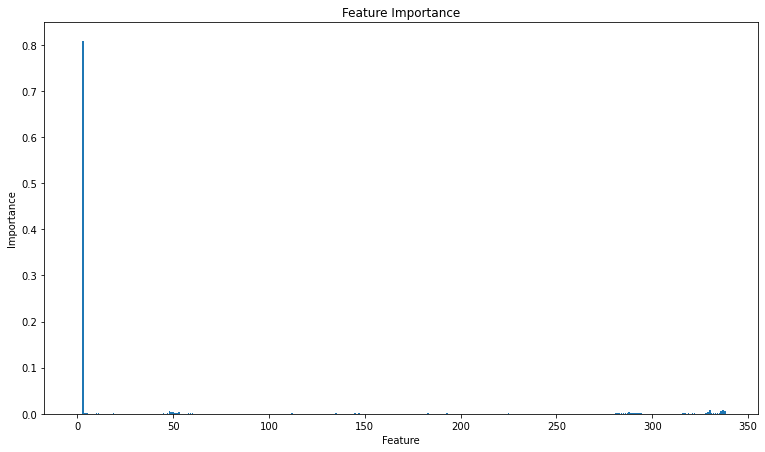

In [12]:
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

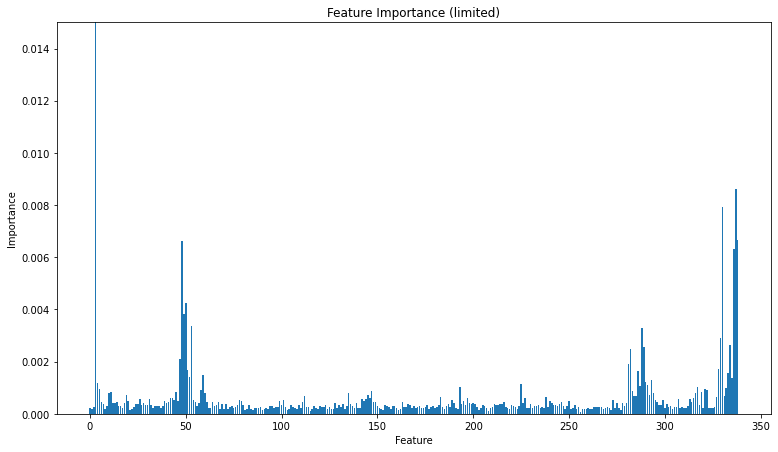

In [13]:
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
# on the top of the bar plot, add the feature names but only for the 20 largest features
plt.title('Feature Importance (limited)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.ylim([0, 0.015])
plt.show()

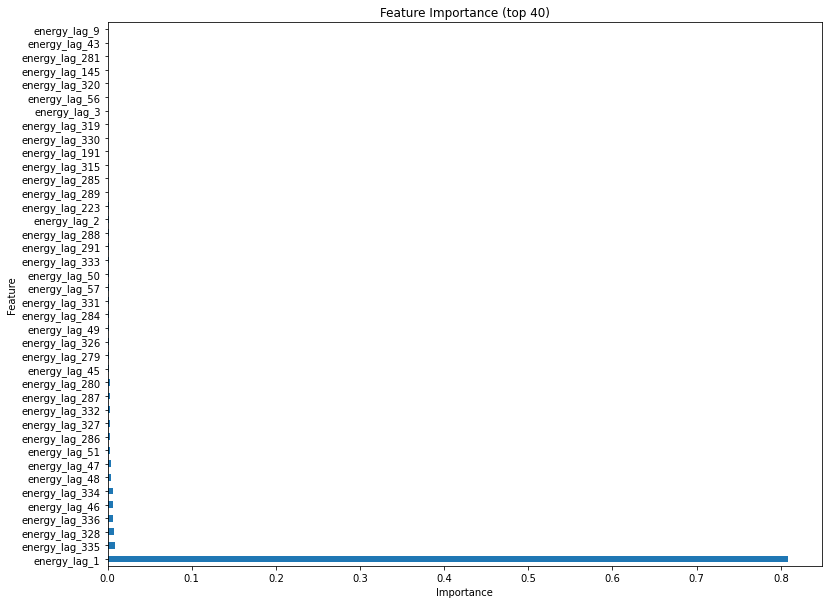

In [14]:
plt.figure(figsize=(12.8, 10))

feature_importance.nlargest(40).plot(kind='barh')
plt.title('Feature Importance (top 40)')
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()

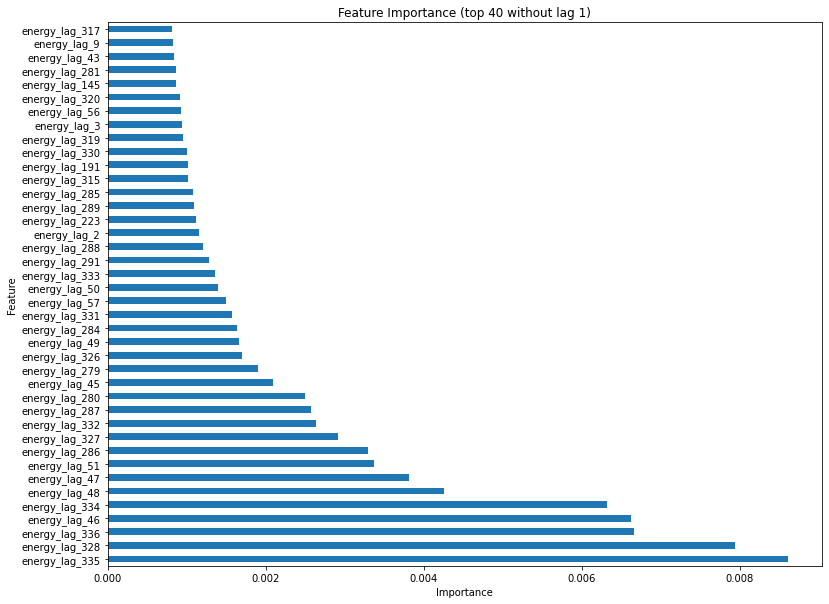

In [15]:
plt.figure(figsize=(12.8, 10))

feature_importance.drop(['energy_lag_1']).nlargest(40).plot(kind='barh')
plt.title('Feature Importance (top 40 without lag 1)')
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()

In [16]:
features = feature_importance.nlargest(40).index
features

Index(['energy_lag_1', 'energy_lag_335', 'energy_lag_328', 'energy_lag_336',
       'energy_lag_46', 'energy_lag_334', 'energy_lag_48', 'energy_lag_47',
       'energy_lag_51', 'energy_lag_286', 'energy_lag_327', 'energy_lag_332',
       'energy_lag_287', 'energy_lag_280', 'energy_lag_45', 'energy_lag_279',
       'energy_lag_326', 'energy_lag_49', 'energy_lag_284', 'energy_lag_331',
       'energy_lag_57', 'energy_lag_50', 'energy_lag_333', 'energy_lag_291',
       'energy_lag_288', 'energy_lag_2', 'energy_lag_223', 'energy_lag_289',
       'energy_lag_285', 'energy_lag_315', 'energy_lag_191', 'energy_lag_330',
       'energy_lag_319', 'energy_lag_3', 'energy_lag_56', 'energy_lag_320',
       'energy_lag_145', 'energy_lag_281', 'energy_lag_43', 'energy_lag_9'],
      dtype='object')

## Test with features worth > 0.5%

- 5x5 casas
- 1x[7 9 12] casas
- 1x80/20

In [17]:
# feature importance larger than 0.5%
features = feature_importance[feature_importance > 0.005].index
features

Index(['energy_lag_1', 'energy_lag_46', 'energy_lag_328', 'energy_lag_334',
       'energy_lag_335', 'energy_lag_336'],
      dtype='object')

In [19]:
df_05 = df[[*features] + ['energy', 'location']]
df_05.head()

,energy_lag_1,energy_lag_46,energy_lag_328,energy_lag_334,energy_lag_335,energy_lag_336,energy,location
33650,1.344,1.414,0.0,0.0,0.0,0.0,1.347,##Northgate House Electricity Supply 1
33651,1.347,1.359,0.0,0.0,0.0,0.0,1.384,##Northgate House Electricity Supply 1
33652,1.384,1.381,0.0,0.0,0.0,0.0,1.344,##Northgate House Electricity Supply 1
33653,1.344,1.296,0.0,0.0,0.0,0.0,1.394,##Northgate House Electricity Supply 1
33654,1.394,1.313,0.0,0.0,0.0,0.0,1.340,##Northgate House Electricity Supply 1


As we can see, the half hour before the energy is the most important, with around the same hour the day before and the last week being also somewhat important.

### 5x5 houses

In [23]:
models = [xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5, tree_method='gpu_hist', verbosity=2) for _ in range(5)]

In [24]:
for model in models:
    # get 5 random houses
    random_locations = np.random.choice(df['location'].unique(), size=5, replace=False)
    # use the 5 houses as the test set
    test = df_05[df_05['location'].isin(random_locations)]
    # remove the houses from the training set
    train = df_05[~df_05['location'].isin(random_locations)]
    X_train = train.drop(['energy', 'location'], axis=1).values
    y_train = train['energy'].values
    X_test = test.drop(['energy', 'location'], axis=1).values
    y_test = test['energy'].values

    init = time.time()
    model.fit(X_train, y_train)
    end = time.time()

    print('Training time: {:.4f} s'.format(end - init))

    init = time.time()
    y_pred = model.predict(X_test)
    end = time.time()

    print('Prediction time: {:.4f} s'.format(end - init))

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)    
    wmape = np.sum(np.abs(y_pred - y_test)) / np.sum(np.abs(y_test)) * 100
    r2 = r2_score(y_test, y_pred)

    print('MSE: {:.4f}'.format(mse))
    print('RMSE: {:.4f}'.format(rmse))
    print('MAE: {:.4f}'.format(mae))
    print('WMAPE: {:.4f}'.format(wmape))
    print('R2: {:.4f}\n'.format(r2))


Training time: 14.7672 s
Prediction time: 0.2244 s
MSE: 0.3704
RMSE: 0.6086
MAE: 0.3053
WMAPE: 18.9405
R2: 0.9234

Training time: 14.0753 s
Prediction time: 0.1893 s
MSE: 0.1798
RMSE: 0.4240
MAE: 0.1727
WMAPE: 21.2881
R2: 0.9048

Training time: 14.4677 s
Prediction time: 0.2756 s
MSE: 1.3460
RMSE: 1.1602
MAE: 0.4177
WMAPE: 11.9769
R2: 0.9708

Training time: 14.0565 s
Prediction time: 0.3514 s
MSE: 0.2441
RMSE: 0.4940
MAE: 0.1861
WMAPE: 14.9444
R2: 0.9519

Training time: 14.4625 s
Prediction time: 0.2330 s
MSE: 0.3098
RMSE: 0.5566
MAE: 0.1819
WMAPE: 17.4994
R2: 0.9234



### 80/20 split

In [25]:
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5, tree_method='gpu_hist', verbosity=2)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df_05.drop(['energy', 'location'], axis=1), df_05['energy'], test_size=0.2, random_state=42)

In [28]:
init = time.time()
model.fit(X_train, y_train)
end = time.time()

print('Training time: {:.4f} s'.format(end - init))

init = time.time()
y_pred = model.predict(X_test)
end = time.time()

print('Prediction time: {:.4f} s'.format(end - init))

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
wmape = np.sum(np.abs(y_pred - y_test)) / np.sum(np.abs(y_test)) * 100
r2 = r2_score(y_test, y_pred)

print('MSE: {:.4f}'.format(mse))
print('RMSE: {:.4f}'.format(rmse))
print('MAE: {:.4f}'.format(mae))
print('WMAPE: {:.4f}'.format(wmape))
print('R2: {:.4f}\n'.format(r2))


Training time: 14.3055 s
Prediction time: 0.5841 s
MSE: 0.4816
RMSE: 0.6940
MAE: 0.2881
WMAPE: 9.3880
R2: 0.9886



## Export Data with the top 40 features

In [22]:
features = [int(f.split("_")[-1]) for f in features]
features

[1,
 328,
 335,
 46,
 336,
 334,
 48,
 47,
 286,
 287,
 280,
 51,
 327,
 284,
 332,
 45,
 331,
 333,
 50,
 49,
 279,
 326,
 315,
 40,
 289,
 288,
 2,
 291,
 320,
 39,
 317,
 57,
 145,
 56,
 292,
 143,
 276,
 220,
 3,
 290]

In [23]:
ddf = pd.read_csv('../data/BANES_v2.csv', parse_dates=['time'])

In [24]:
for i in tqdm(range(len(features))):
    f = features[i]
    ddf.loc[ddf['time'].shift(f) == ddf['time'] - pd.Timedelta(f * 30, 'm'), f"energy_lag_{f}"] = ddf['energy'].shift(f)

100%|██████████| 40/40 [00:33<00:00,  1.20it/s]


In [25]:
ddf = ddf.dropna()


In [26]:
ddf.to_csv('../data/BANES_v4_featureimportance.csv', index=False)

# XGBoost training

In [27]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7618080 entries, 336 to 7759967
Data columns (total 46 columns):
 #   Column            Dtype              
---  ------            -----              
 0   location          object             
 1   time              datetime64[ns, UTC]
 2   energy            float64            
 3   AirTemp           float64            
 4   RelativeHumidity  float64            
 5   Dni               float64            
 6   energy_lag_1      float64            
 7   energy_lag_328    float64            
 8   energy_lag_335    float64            
 9   energy_lag_46     float64            
 10  energy_lag_336    float64            
 11  energy_lag_334    float64            
 12  energy_lag_48     float64            
 13  energy_lag_47     float64            
 14  energy_lag_286    float64            
 15  energy_lag_287    float64            
 16  energy_lag_280    float64            
 17  energy_lag_51     float64            
 18  energy_lag_327    fl

In [28]:
ddf.describe()

,energy,AirTemp,RelativeHumidity,Dni,energy_lag_1,energy_lag_328,energy_lag_335,energy_lag_46,energy_lag_336,energy_lag_334,...,energy_lag_317,energy_lag_57,energy_lag_145,energy_lag_56,energy_lag_292,energy_lag_143,energy_lag_276,energy_lag_220,energy_lag_3,energy_lag_290
count,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,...,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06,7.618080e+06
mean,4.047301e+00,1.037881e+01,8.224648e-01,9.455131e+01,4.047312e+00,4.045944e+00,4.045883e+00,4.047256e+00,4.045876e+00,4.045890e+00,...,4.046194e+00,4.047229e+00,4.046361e+00,4.047236e+00,4.046653e+00,4.046348e+00,4.046644e+00,4.046735e+00,4.047327e+00,4.046660e+00
std,8.456606e+00,5.630281e+00,1.291052e-01,2.143843e+02,8.456609e+00,8.456158e+00,8.456215e+00,8.456330e+00,8.456223e+00,8.456208e+00,...,8.456348e+00,8.456297e+00,8.455656e+00,8.456302e+00,8.457062e+00,8.455644e+00,8.457053e+00,8.456899e+00,8.456609e+00,8.457062e+00
min,0.000000e+00,-9.000000e+00,3.060000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.290000e-01,6.400000e+00,7.450000e-01,0.000000e+00,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01,...,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01,2.290000e-01
50%,7.630000e-01,1.030000e+01,8.590000e-01,0.000000e+00,7.630000e-01,7.620000e-01,7.620000e-01,7.630000e-01,7.620000e-01,7.620000e-01,...,7.620000e-01,7.630000e-01,7.630000e-01,7.630000e-01,7.630000e-01,7.630000e-01,7.630000e-01,7.630000e-01,7.630000e-01,7.630000e-01
75%,3.258000e+00,1.440000e+01,9.260000e-01,1.500000e+01,3.258000e+00,3.255000e+00,3.255000e+00,3.258000e+00,3.255000e+00,3.255000e+00,...,3.255000e+00,3.258000e+00,3.257000e+00,3.258000e+00,3.256000e+00,3.257000e+00,3.256000e+00,3.256000e+00,3.258000e+00,3.256000e+00
max,7.470000e+01,2.970000e+01,1.000000e+00,9.460000e+02,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01,...,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01,7.470000e+01


In [30]:
X_train, X_test, y_train, y_test = train_test_split(ddf[[f"energy_lag_{f}" for f in features]], ddf['energy'], test_size=0.2, random_state=42)

In [31]:
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5, tree_method='gpu_hist', verbosity=2)

In [32]:
init = time.time()
model.fit(X_train, y_train)
end = time.time()

print('Training time: {:.4f} s'.format(end - init))

Training time: 243.8325 s


In [33]:
init = time.time()
preds = model.predict(X_test)
end = time.time()

print('Prediction time: {:.4f} s'.format(end - init))

Prediction time: 8.5927 s


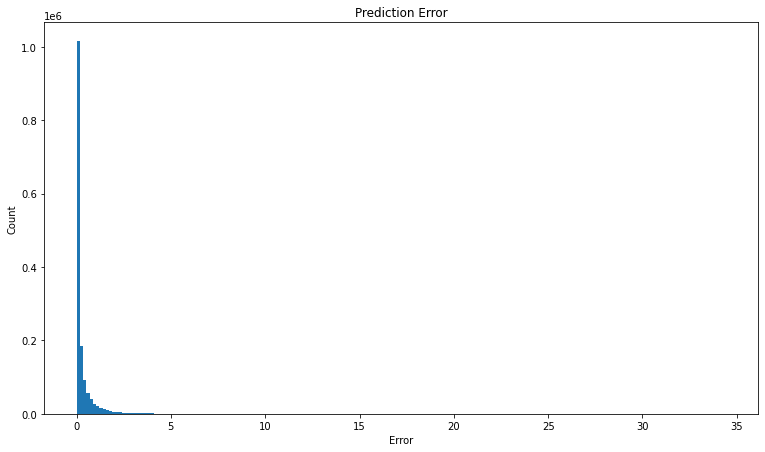

In [34]:
# plot error histogram
plt.hist(np.abs(preds - y_test), bins=200)
plt.title('Prediction Error')
plt.xlabel('Error')
plt.ylabel('Count')
plt.show()

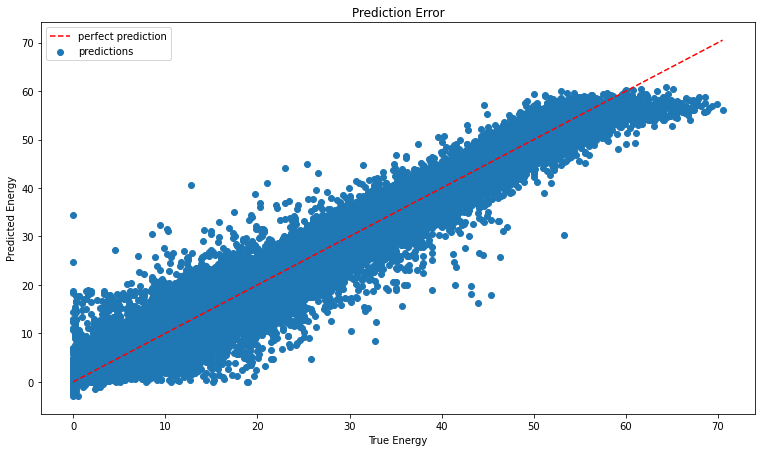

In [35]:
plt.scatter(y_test, preds)
plt.title('Prediction Error')
plt.xlabel('True Energy')
plt.ylabel('Predicted Energy')
plt.plot([0, max(y_test)], [0, max(y_test)], '--', color='red')
plt.legend(['perfect prediction', 'predictions'])
plt.show()

In [36]:
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds)
wmape = np.sum(np.abs(preds - y_test)) / np.sum(np.abs(y_test)) * 100
r2 = r2_score(y_test, preds)

print('MSE: {:.4f} kWh'.format(mse))
print('RMSE: {:.4f} kWh'.format(rmse))
print('MAE: {:.4f} kWh'.format(mae))
print('WMAPE: {:.4f} %'.format(wmape))
print('R2: {:.4f}'.format(r2))


MSE: 0.5187 kWh
RMSE: 0.7202 kWh
MAE: 0.2924 kWh
WMAPE: 7.2161 %
R2: 0.9928


## Use houses as training data

In [37]:
ddf.location.nunique()

69

In [38]:
ddf.location.value_counts()

Guildhall Electricity Supply 1 (HH)              228384
Bath Central Library Electricity (HH)            224784
##Weston Library Electricity Supply 1            197376
Royal Victoria Park Nursery Electricity          196848
Moorland Rd Library                              194304
                                                  ...  
Mechanical Control Panel 1                         7536
Ground & First Floor North - Power & Lighting      7536
Air cooled chiller 1                               2352
AirCooled Chiller 2                                 432
Ground Floor Disabled WC Water Heater                96
Name: location, Length: 69, dtype: int64

In [58]:
# get 10 random locations
locations = ddf.location.sample(10).values
locations

array(['St Johns Primary Oldfield Lane BATH BA2',
       'Keynsham Library & One Stop Shop (P272 HH)',
       'Keynsham Library & One Stop Shop (P272 HH)',
       'St Johns Primary Oldfield Lane BATH BA2',
       'The Hollies Offices MSN Car Park Barrier',
       'Swallow Street Stores & Workshop Electri',
       '##Nothgate House Electricity Supply 3',
       'Junior School Electricity - Kitchen',
       'Castle Primary School (HH) (New Supply)',
       'Pensford Primary School - Kitchen'], dtype=object)

In [59]:
test = ddf[ddf.location.isin(locations)]
train = ddf[~ddf.location.isin(locations)]
print(test.shape, train.shape)

X_train = train[[f"energy_lag_{f}" for f in features]]
y_train = train['energy']
X_test = test[[f"energy_lag_{f}" for f in features]]
y_test = test['energy']

(1074816, 46) (6543264, 46)


In [60]:
test.shape[0] / train.shape[0] * 100

16.426297334174503

In [65]:
model2 = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5, tree_method='gpu_hist', verbosity=2)

In [66]:
init = time.time()
model2.fit(X_train, y_train)
end = time.time()

print('Training time: {:.4f} s'.format(end - init))

XGBoostError: bad allocation

In [ ]:
init = time.time()
preds2 = model2.predict(X_test)
end = time.time()

print('Prediction time: {:.4f} s'.format(end - init))

Prediction time: 6.1365 s


In [ ]:
mse = mean_squared_error(y_test, preds2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds2)
wmape = np.sum(np.abs(preds2 - y_test)) / np.sum(np.abs(y_test)) * 100
r2 = r2_score(y_test, preds2)

print('MSE: {:.4f} kWh'.format(mse))
print('RMSE: {:.4f} kWh'.format(rmse))
print('MAE: {:.4f} kWh'.format(mae))
print('WMAPE: {:.4f} %'.format(wmape))
print('R2: {:.4f}'.format(r2))

MSE: 0.1474 kWh
RMSE: 0.3840 kWh
MAE: 0.1674 kWh
WMAPE: 9.1390 %
R2: 0.9811


## Test with different features

In the previous section, we trained the model on the whole top 40 features. In this section we will further limit the features.

In [41]:
feature_importance.head(10)

AirTemp             0.000239
RelativeHumidity    0.000184
Dni                 0.000232
energy_lag_1        0.804968
energy_lag_2        0.001172
energy_lag_3        0.000813
energy_lag_4        0.000436
energy_lag_5        0.000303
energy_lag_6        0.000242
energy_lag_7        0.000189
dtype: float32

In [44]:
limit_5pc = feature_importance.where(feature_importance > 0.005).dropna()
limit_5pc

energy_lag_1      0.804968
energy_lag_46     0.008218
energy_lag_328    0.009736
energy_lag_334    0.005625
energy_lag_335    0.008320
energy_lag_336    0.007290
dtype: float32

In [48]:
X_train = train[limit_5pc.index]
y_train = train['energy']
X_test = test[limit_5pc.index]
y_test = test['energy']

In [47]:
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=5, tree_method='gpu_hist', verbosity=2)

In [49]:
init = time.time()
model.fit(X_train, y_train)
end = time.time()

print('Training time: {:.4f} s'.format(end - init))


Training time: 442.4856 s


In [50]:
init = time.time()
preds = model.predict(X_test)
end = time.time()

print('Prediction time: {:.4f} s'.format(end - init))


Prediction time: 2.7311 s


In [51]:
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, preds)
wmape = np.sum(np.abs(preds - y_test)) / np.sum(np.abs(y_test)) * 100
r2 = r2_score(y_test, preds)

print('MSE: {:.4f} kWh'.format(mse))
print('RMSE: {:.4f} kWh'.format(rmse))
print('MAE: {:.4f} kWh'.format(mae))
print('WMAPE: {:.4f} %'.format(wmape))
print('R2: {:.4f}'.format(r2))


MSE: 1.2742 kWh
RMSE: 1.1288 kWh
MAE: 0.4775 kWh
WMAPE: 12.3203 %
R2: 0.9726
